In this notebook we are going to generate the physiological regressors for one subject from the human connectome and compute their statistical maps.

In [1]:
import numpy as np
from nilearn.image import load_img
import sys
sys.path.append("../code")

from nilearn import plotting
from nilearn.image import math_img

/home/javi/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
hcp_log_data = np.loadtxt("../data/hcp/100307/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_Physio_log.txt")
bold_img = load_img("../data/hcp/100307/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR.nii.gz")
motion = np.loadtxt("../data/hcp/100307/MNINonLinear/Results/rfMRI_REST1_LR/Movement_Regressors.txt")
n_samples = bold_img.shape[-1]
repetition_time = 0.72
frame_times = np.arange(n_samples)*repetition_time

In [11]:
pd.read_csv("../data/hcp/100307/MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR_Physio_log.txt", 
            sep="\t", header=None).head()

,0,1,2
0,1,975,2513
1,1,960,2500
2,1,960,2490
3,1,946,2480
4,1,946,2470


From the humann connectome documentation:

*We also acquire cardiac and respiratory signals associated with each functional MR scan, using 
a standard Siemens pulse oximeter placed on a digit and a respiratory belt placed on the 
abdomen.  These signals are linked to scan onset using a trigger pulse generated by the pulse 
sequence.  They are written to text files and assigned unique file names that enable matching to 
the corresponding scan. These raw files were processed to create a file format expected by 
FSL's PNM. They are combined into a 3-column physio text file starting from the onset of the 
first trigger pulse through to the end of the last acquired frame. They are all sampled equally at 
400 Hz, meaning there are roughly 288 samples per frame for functional images. In the 
aggregate file the **first** column is used for the **trigger** pulse information, the **second** for 
**respiratory** information, and the **third** column for **pulse** oximeter (i.e., cardiac) information.*

In [3]:
# So the second column to the respiratary signal, and the third one corresponds to ECG
resp_signal = hcp_log_data[:,1]
puls_signal = hcp_log_data[:,2]

In [4]:
from regressors import RetroicorPhysio, RVPhysio, HVPhysio, DownsamplePhysio

In [5]:
retroicor = RetroicorPhysio(physio_rate=400, 
                           t_r=repetition_time, 
                           transform="mean",
                           delta=200, 
                           high_pass=0.1, 
                           low_pass=3.0, 
                           order=1)
puls_retroicor = retroicor.compute_regressors(signal=puls_signal, time_scan=frame_times)

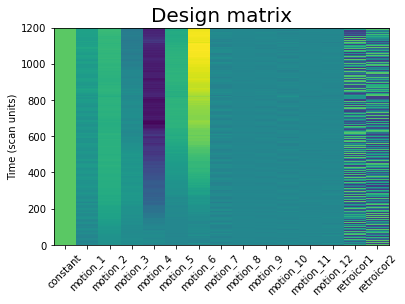

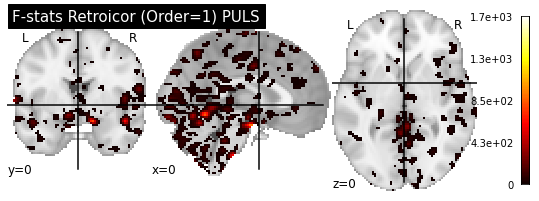

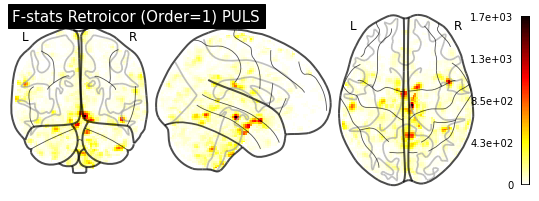

In [6]:
from nilearn.glm.first_level import FirstLevelModel

first_level = FirstLevelModel(drift_model=None, noise_model='ols', signal_scaling=False, smoothing_fwhm=6)
dm = pd.DataFrame(np.column_stack(([1]*n_samples,  motion, puls_retroicor)), 
                  columns= ["constant"] + [f"motion_{ii+1}" for ii in range(motion.shape[1])] +
                  ["retroicor1", "retroicor2"])
dm.head()

fig, ax = plt.subplots()
ax.pcolormesh(dm)
ax.set_xticks(np.arange(dm.shape[1])+0.5)
ax.set_xticklabels(dm.columns, rotation=45)
ax.set_ylabel("Time (scan units)")
ax.set_title("Design matrix", size=20)
pass

first_level.fit(bold_img, design_matrices=dm)
res_retroicor_dict = first_level.compute_contrast("retroicor1+retroicor2", stat_type="F", output_type="all")

plotting.plot_stat_map(math_img("img1*(img2<0.0001)", 
                                img1=res_retroicor_dict['stat'], 
                                img2=res_retroicor_dict['p_value']), 
                       cut_coords=(0,0,0), title="F-stats Retroicor (Order=1) PULS")

plotting.plot_glass_brain(math_img("img1*(img2<0.0001)", 
                                   img1=res_retroicor_dict['stat'], 
                                   img2=res_retroicor_dict['p_value']), 
                       colorbar=True, title="F-stats Retroicor (Order=1) PULS")

# Variations model

(0.0, 1000.0)

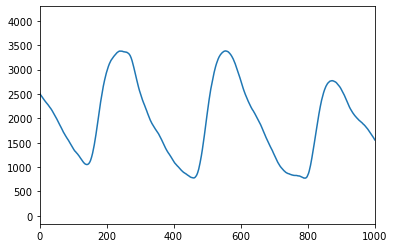

In [119]:
plt.plot(puls_signal)
plt.xlim([0,1000])

In [7]:
resp_variations = RVPhysio(physio_rate=400, 
                          t_r=repetition_time, 
                          filtering=None).compute_regressors(resp_signal, frame_times)

puls_variations = RVPhysio(physio_rate=400, 
                          t_r=repetition_time, 
                          filtering="gaussian", 
                          low_pass=1/0.4).compute_regressors(puls_signal, frame_times)
    

# TODO: See how to handle this signal and variations in heart rate. Scanner repetition time (720 ms)
# smaller than usual heart rate (~ 75 bpm, i.e. 1.25 beat/sec, so in a 2TR window this gives ~ < 2 beats),
# so algorithm fails to find inter-event time differences...

#puls_variation = HVPhysio(physio_rate=400, 
 #                         t_r=repetition_time, 
  #                        delta=100,
   #                       transform="mean", 
    #                      peak_rise=0.1,
     #                     filtering="gaussian", low_pass=1).compute_regressors(signal=puls_signal, time_scan=frame_times)

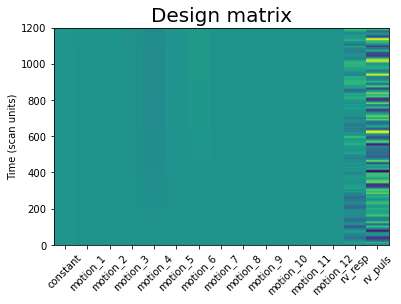

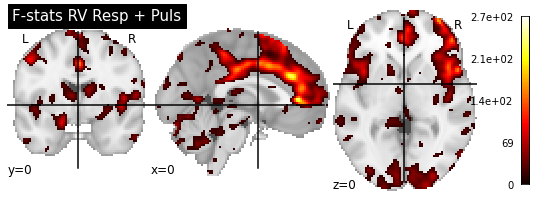

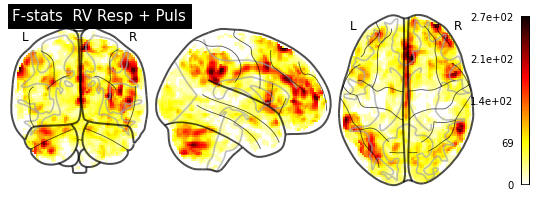

In [9]:
from nilearn.glm.first_level import FirstLevelModel

first_level = FirstLevelModel(drift_model=None, noise_model='ols', signal_scaling=False, smoothing_fwhm=6)
dm = pd.DataFrame(np.column_stack(([1]*n_samples,  motion, resp_variations, puls_variations)), 
                  columns= ["constant"] + [f"motion_{ii+1}" for ii in range(motion.shape[1])] +
                  ["rv_resp", "rv_puls"])
dm.head()


fig, ax = plt.subplots()
ax.pcolormesh(dm)
ax.set_xticks(np.arange(dm.shape[1])+0.5)
ax.set_xticklabels(dm.columns, rotation=45)
ax.set_ylabel("Time (scan units)")
ax.set_title("Design matrix", size=20)
pass

first_level.fit(bold_img, design_matrices=dm)
res_variations_dict = first_level.compute_contrast("rv_resp+rv_puls", stat_type="F", output_type="all")

plotting.plot_stat_map(math_img("img1*(img2<0.0001)", 
                                img1=res_variations_dict['stat'], 
                                img2=res_variations_dict['p_value']), 
                       cut_coords=(0,0,0), title="F-stats RV Resp + Puls")

plotting.plot_glass_brain(math_img("img1*(img2<0.0001)", 
                                   img1=res_variations_dict['stat'], 
                                   img2=res_variations_dict['p_value']), 
                       colorbar=True, title="F-stats  RV Resp + Puls")

# Downsample Pulse OX signal...

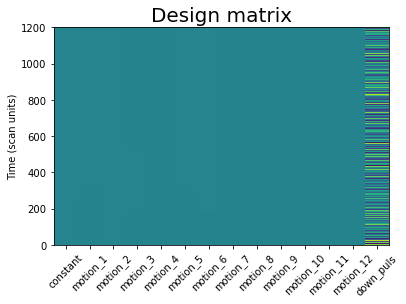

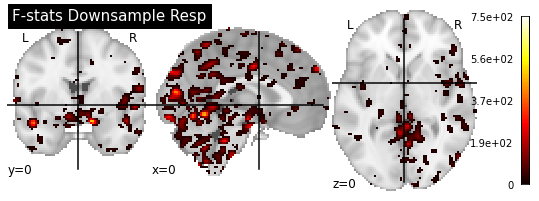

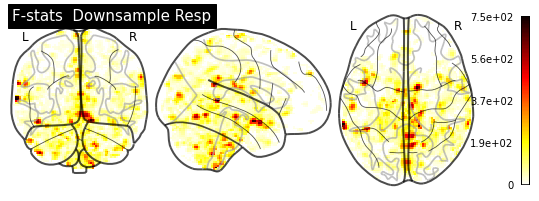

In [10]:
downsample = DownsamplePhysio(physio_rate=400, t_r=repetition_time)
puls_downsample = downsample.compute_regressors(signal=puls_signal, time_scan=frame_times)

first_level = FirstLevelModel(drift_model=None, noise_model='ols', signal_scaling=False, smoothing_fwhm=6)
dm = pd.DataFrame(np.column_stack(([1]*n_samples,  motion, puls_downsample)), 
                  columns= ["constant"] + [f"motion_{ii+1}" for ii in range(motion.shape[1])] +
                  ["down_puls"])
dm.head()


fig, ax = plt.subplots()
ax.pcolormesh(dm)
ax.set_xticks(np.arange(dm.shape[1])+0.5)
ax.set_xticklabels(dm.columns, rotation=45)
ax.set_ylabel("Time (scan units)")
ax.set_title("Design matrix", size=20)
pass

first_level.fit(bold_img, design_matrices=dm)
res_downsample_dict = first_level.compute_contrast("down_puls", stat_type="F", output_type="all")

plotting.plot_stat_map(math_img("img1*(img2<0.0001)", 
                                img1=res_downsample_dict['stat'], 
                                img2=res_downsample_dict['p_value']), 
                       cut_coords=(0,0,0), title="F-stats Downsample Resp")

plotting.plot_glass_brain(math_img("img1*(img2<0.0001)", 
                                   img1=res_downsample_dict['stat'], 
                                   img2=res_downsample_dict['p_value']), 
                       colorbar=True, title="F-stats  Downsample Resp")

## Compare this with using the signal in white matter and csf...

running  mri_binarize --i ../data/hcp/100307/MNINonLinear/aparc+aseg.nii.gz --o wm_csf_mask.nii.gz --wm+vcsf

$Id: mri_binarize.c,v 1.43 2016/06/09 20:46:21 greve Exp $
cwd /home/javi/Documentos/brainhack-physio-project/notebooks
cmdline mri_binarize.bin --i ../data/hcp/100307/MNINonLinear/aparc+aseg.nii.gz --o wm_csf_mask.nii.gz --wm+vcsf 
sysname  Linux
hostname javi-Thelio-Major
machine  x86_64
user     javi

input      ../data/hcp/100307/MNINonLinear/aparc+aseg.nii.gz
frame      0
nErode3d   0
nErode2d   0
output     wm_csf_mask.nii.gz
Binarizing based on matching values
nMatch 18
 0     2
 1    41
 2    77
 3   251
 4   252
 5   253
 6   254
 7   255
 8     7
 9    46
10     4
11     5
12    14
13    43
14    44
15    72
16    31
17    63
binval        1
binvalnot     0
fstart = 0, fend = 0, nframes = 1
Found 1823063 values in range
Counting number of voxels in first frame
Found 1823063 voxels in final mask
Count: 1823063 625310.599438 21023600 8.671507
mri_binarize done


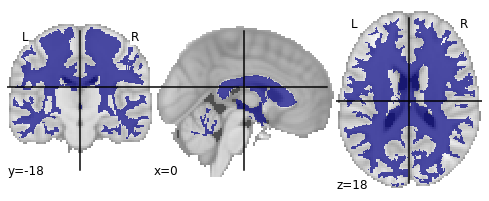

In [75]:
# First, extract WM + CSF  mask
in_file  = "../data/hcp/100307/MNINonLinear/aparc+aseg.nii.gz"
cmd = f"mri_binarize --i {in_file} --o wm_csf_mask.nii.gz --wm+vcsf"
print("running ", cmd)
os.system(cmd)
plotting.plot_roi("wm_csf_mask.nii.gz")

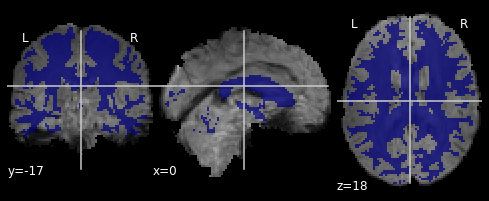

In [148]:
# extract signal within this mask
from nilearn.image import resample_to_img, mean_img
from nilearn.masking import apply_mask

wmcsf_mask_bold = resample_to_img("wm_csf_mask.nii.gz", mean_img(bold_img), interpolation="nearest")
wm_csf_signal = apply_mask(bold_img, wmcsf_mask_bold)
plotting.plot_roi(wmcsf_mask_bold, bg_img=mean_img(bold_img))

In [149]:
# Compute 6 first PCs from the voxels here
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
acompcor_regs = pca.fit_transform(wm_csf_signal)
print(f"these explained about {np.cumsum(pca.explained_variance_ratio_).max()*100:.2f}% variability")

these explained about 40.86% variability


In [116]:
# Contruct new design matrix
dm_acompcor = pd.DataFrame(np.column_stack(([1]*n_samples,  motion, acompcor_regs)), 
                           columns= ["constant"] + [f"motion_{ii+1}" for ii in range(motion.shape[1])] +
                           ["pc1", "pc2", "pc3", "pc4", "pc5", "pc6"])
dm_acompcor.head()

,constant,motion_1,motion_2,motion_3,motion_4,motion_5,motion_6,motion_7,motion_8,motion_9,motion_10,motion_11,motion_12,pc1,pc2,pc3,pc4,pc5,pc6
0,1.0,0.000000,0.110733,0.108724,0.010657,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,114299.632812,-47428.750000,28627.988281,-18472.970703,-2937.613770,2295.842773
1,1.0,-0.038440,0.117214,0.078874,0.004813,0.0,0.000000,-0.038440,0.006481,-0.029850,-0.005844,0.0,0.000000,111645.273438,-45534.003906,28399.701172,-19357.472656,-3367.405029,1598.984131
2,1.0,0.032012,0.133356,0.101555,0.003953,0.0,0.000000,0.070452,0.016142,0.022681,-0.000860,0.0,0.000000,114886.156250,-44937.199219,28785.062500,-15527.831055,-2715.158936,-4892.270508
3,1.0,0.040458,0.143815,0.102566,0.000000,0.0,0.000000,0.008446,0.010459,0.001011,-0.003953,0.0,0.000000,112403.421875,-43808.429688,28835.406250,-13391.993164,-3003.552734,-7087.681152
4,1.0,-0.045640,0.122017,0.054368,0.000000,0.0,0.109435,-0.086098,-0.021798,-0.048198,0.000000,0.0,0.109435,112116.914062,-46739.171875,30155.742188,-18657.296875,-3494.102051,-8918.366211


In [143]:
first_level.fit(bold_img, design_matrices=dm_acompcor)
res_dict_acompcor = first_level.compute_contrast("pc1+pc2+pc3+pc4+pc5+pc6", stat_type="F", output_type="all")

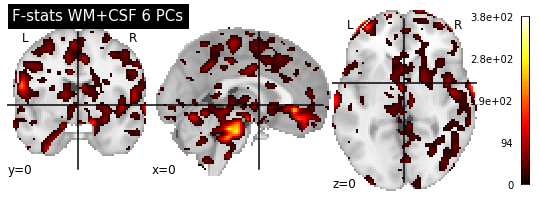

In [146]:
from nilearn import plotting
from nilearn.image import math_img
plotting.plot_stat_map(math_img("img1*(img2<0.0001)", 
                                img1=res_dict_acompcor['stat'], 
                                img2=res_dict_acompcor['p_value']), 
                       cut_coords=(0,0,0), title="F-stats WM+CSF 6 PCs")

In [137]:
apply_mask(res_dict['stat'], math_img("img1==1", img1=wmcsf_mask_bold)).shape

(78126,)